In [2]:
pip install pandas scikit-learn fasttext tensorflow


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.4/73.4 kB 4.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached pybind11-2.13.1-py3-none-any.whl.metadata (9.5 kB)
Using cached pybind11-2.13.1-py3-none-any.whl (238 kB)
  Created wheel for fasttext: filename=fasttext-0.9.3-cp310-cp310-linux_x86_64.whl size=4246767 sha256=303ad8d92a4e2367d3731e2551495156acf045d0305afe4b3e154c57fa5f90c5
  Stored in directory: /root/.cache/pip/wheels/0d/a2/00/81db54d3e6a8199b829d58e02cec2ddb20ce3e59fad8d3c92a
Successfully built fasttext


In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Load datasets
fake_df = pd.read_csv('Fake.csv')
true_df = pd.read_csv('True.csv')

# Add labels
fake_df['label'] = 0
true_df['label'] = 1

# Combine datasets
df = pd.concat([fake_df, true_df]).reset_index(drop=True)

# Shuffle the dataset
df = df.sample(frac=1).reset_index(drop=True)

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['label'], test_size=0.2, random_state=42)

# Convert labels to categorical if necessary
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)


In [4]:
import fasttext

# Prepare text data for FastText
with open('train.txt', 'w') as f:
    for text, label in zip(X_train, y_train):
        f.write(f'__label__{label} {text}\n')

with open('test.txt', 'w') as f:
    for text, label in zip(X_test, y_test):
        f.write(f'__label__{label} {text}\n')

# Train FastText model
model = fasttext.train_n.supervised('traitxt', label='__label__')
model.save_model('fasttext_model.bin')


In [5]:
import numpy as np

def get_fasttext_embeddings(texts, model):
    embeddings = [model.get_sentence_vector(text) for text in texts]
    return np.array(embeddings)

# Load FastText model
ft_model = fasttext.load_model('fasttext_model.bin')

# Get embeddings
X_train_embeddings = get_fasttext_embeddings(X_train, ft_model)
X_test_embeddings = get_fasttext_embeddings(X_test, ft_model)


In [6]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout

# Define CNN model
def create_cnn_model(input_shape):
    model = Sequential([
        Conv1D(filters=64, kernel_size=5, activation='relu', input_shape=input_shape),
        MaxPooling1D(pool_size=2),
        Conv1D(filters=128, kernel_size=5, activation='relu'),
        MaxPooling1D(pool_size=2),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(2, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Create and train model
input_shape = (X_train_embeddings.shape[1], 1)
model_cnn = create_cnn_model(input_shape)
X_train_embeddings = np.expand_dims(X_train_embeddings, axis=2)
X_test_embeddings = np.expand_dims(X_test_embeddings, axis=2)

model_cnn.fit(X_train_embeddings, y_train, epochs=5, batch_size=32, validation_split=0.1)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 26s 23ms/step - accuracy: 0.9882 - loss: 0.0634 - val_accuracy: 0.9972 - val_loss: 0.0096
Epoch 2/5
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 21s 21ms/step - accuracy: 0.9972 - loss: 0.0106 - val_accuracy: 0.9981 - val_loss: 0.0093
Epoch 3/5
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 24s 24ms/step - accuracy: 0.9975 - loss: 0.0113 - val_accuracy: 0.9969 - val_loss: 0.0117
Epoch 4/5
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 38s 21ms/step - accuracy: 0.9980 - loss: 0.0096 - val_accuracy: 0.9969 - val_loss: 0.0098
Epoch 5/5
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 25s 25ms/step - accuracy: 0.9981 - loss: 0.0077 - val_accuracy: 0.9969 - val_loss: 0.0102


281/281 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
Accuracy: 0.9954
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      4682
           1       0.99      1.00      1.00      4298

    accuracy                           1.00      8980
   macro avg       1.00      1.00      1.00      8980
weighted avg       1.00      1.00      1.00      8980



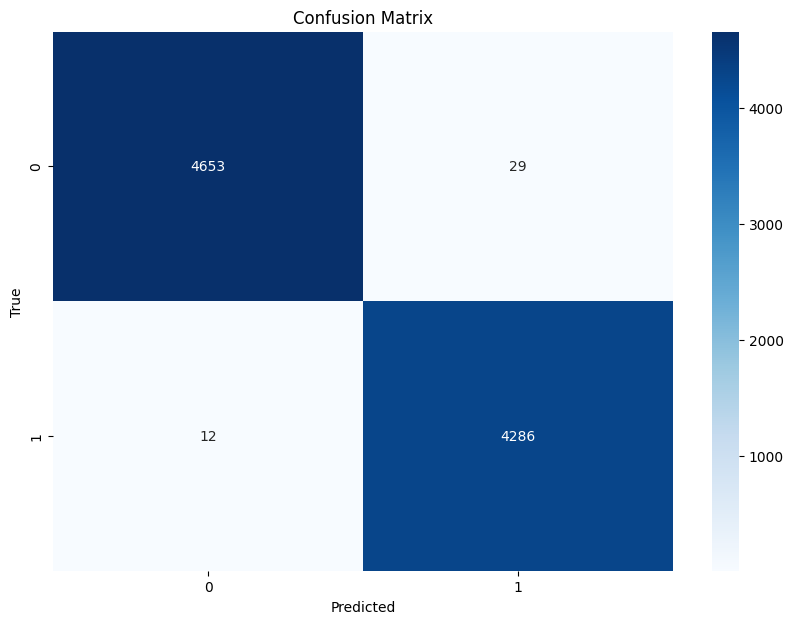

In [7]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Evaluate model
y_pred = model_cnn.predict(X_test_embeddings)
y_pred_classes = np.argmax(y_pred, axis=1)

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred_classes)
conf_matrix = confusion_matrix(y_test, y_pred_classes)
class_report = classification_report(y_test, y_pred_classes)

print(f'Accuracy: {accuracy:.4f}')
print(f'Classification Report:\n{class_report}')

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [10]:
# Save the CNN model
model_cnn.save('cnn_model.h5')
